In [1]:
import tensorflow as tf
import numpy as np
import os
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

f = open('data.txt', 'r')

data_x = []
data_y = []

for i, tt in enumerate(f):
    if(i>0):
        tmp = tt.split()
        if(i==1):
            prev = [float(tmp[0]), float(tmp[1])] 
        data_x.append([float(tmp[2]), float(tmp[3]), float(tmp[4]), prev[0], prev[1]])
        data_y.append([float(tmp[0]), float(tmp[1])])
        prev = data_y[-1]         

def normalize(t, max_, min_):
    return (t - min_) / (max_ - min_)

fulldata_x = np.array(data_x, dtype=float)
fulldata_y = np.array(data_y, dtype=float) + 0.4
max1, max2, max3, max4, max5 = max(fulldata_x[:, 0]), max(fulldata_x[:, 1]), max(fulldata_x[:, 2]), max(fulldata_x[:, 3]), max(fulldata_x[:, 4])
min1, min2, min3, min4, min5 = min(fulldata_x[:, 0]), min(fulldata_x[:, 1]), min(fulldata_x[:, 2]), min(fulldata_x[:, 3]), min(fulldata_x[:, 4])

fulldata_x[:, 0] = normalize(fulldata_x[:, 0], max1+0.6, min1-0.6)
fulldata_x[:, 1] = normalize(fulldata_x[:, 1], max2+0.6, min2-0.6)
fulldata_x[:, 2] = normalize(fulldata_x[:, 2], max3+0.6, min3-0.6)
fulldata_x[:, 3] = normalize(fulldata_x[:, 3], max4+0.02, min4-0.02)
fulldata_x[:, 4] = normalize(fulldata_x[:, 4], max5+0.02, min5-0.02)

print(max(fulldata_x[:, 0]), max(fulldata_x[:, 1]), max(fulldata_x[:, 2]), max(fulldata_x[:, 3]), max(fulldata_x[:, 4]))
print(min(fulldata_x[:, 0]), min(fulldata_x[:, 1]), min(fulldata_x[:, 2]), min(fulldata_x[:, 3]), min(fulldata_x[:, 4]))

0.885673803352 0.886284509335 0.898647912476 0.893253059634 0.893253059634
0.114326196648 0.113715490665 0.101352087524 0.106746940366 0.106746940366


In [2]:
train_x = fulldata_x
train_y = fulldata_y

In [3]:
num = train_x.shape[0]
batch_size = 500 
in_dim = train_x.shape[1]
out_dim = train_y.shape[1]
init_lr = 0.01
decay_steps = 1000
decay_rate = 0.96
num_batch = int(num/ batch_size)

### Model

In [4]:
# inputs
x = tf.placeholder('float32', [batch_size, in_dim], name='x')
y = tf.placeholder('float32', [batch_size, out_dim], name='y')

W1 = tf.Variable(tf.truncated_normal([in_dim, 100]), name='W1')
b1 = tf.Variable(tf.zeros([100]), name='b1')
h1 = tf.sigmoid(tf.matmul(x, W1) + b1)

W2 = tf.Variable(tf.truncated_normal([100, 20]), name='W2')
b2 = tf.Variable(tf.zeros([20]), name='b2')
h2 = tf.sigmoid(tf.matmul(h1, W2) + b2)

W3 = tf.Variable(tf.truncated_normal([20, 10]), name='W3')
b3 = tf.Variable(tf.zeros([10]), name='b3')
h3 = tf.sigmoid(tf.matmul(h2, W3) + b3)

W4 = tf.Variable(tf.truncated_normal([10, 10]), name='W4')
b4 = tf.Variable(tf.zeros([10]), name='b4')
h4 = tf.sigmoid(tf.matmul(h3, W4) + b4)

W5 = tf.Variable(tf.truncated_normal([10, out_dim]), name='W5')
b5  = tf.Variable(tf.zeros([out_dim]), name='b5')
h5 = tf.sigmoid(tf.matmul(h4, W5) + b5)

loss = tf.losses.mean_squared_error(y, h5)
global_step  = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(init_lr,  global_step, decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
saver = tf.train.Saver(tf.global_variables())

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())                          # For initializing all the variables

In [5]:
epochs = 10000
loss_collection = []
for i in range(epochs):
    total_loss = 0
    rand = np.random.randint(0, len(train_x), len(train_x))
    train_xr = train_x[rand]
    train_yr = train_y[rand]
    for rr in range(num_batch):
        input_x = train_x[batch_size*rr:batch_size*(rr+1)]
        input_y = train_y[batch_size*rr:batch_size*(rr+1)]
        _, _loss, step = sess.run([optimizer, loss, global_step], feed_dict={x:input_x, y:input_y})
        total_loss += _loss
    loss_collection.append(total_loss/num_batch)  
    if(i%100==0):
            print("train", i, total_loss/num_batch) 
saver.save(sess, save_path="nn_model/")                         

train 0 0.0164667127344
train 100 1.23009420147e-05
train 200 6.55778836113e-06
train 300 1.34725634982e-05
train 400 1.19091498366e-05
train 500 8.06683629485e-06
train 600 5.62251658367e-06
train 700 1.06478549545e-05
train 800 4.86924813635e-06
train 900 1.85840747867e-06
train 1000 1.18131035833e-05
train 1100 3.2594878121e-06
train 1200 3.17694602422e-05
train 1300 8.22333367978e-06
train 1400 4.47414615539e-06
train 1500 2.30267978749e-06
train 1600 3.467082681e-06
train 1700 5.00319626124e-06
train 1800 1.70412933029e-06
train 1900 6.05365448791e-06
train 2000 8.92053891574e-06
train 2100 1.72286127685e-06
train 2200 5.83704743601e-06
train 2300 3.38812162681e-06
train 2400 2.0011508847e-06
train 2500 1.56827182107e-05
train 2600 7.422025836e-06
train 2700 1.94183477081e-06
train 2800 1.59129501122e-06
train 2900 1.60243397494e-06
train 3000 1.03590866729e-05
train 3100 1.5638884463e-06
train 3200 1.57886377868e-06
train 3300 1.57519051274e-06
train 3400 6.82840443586e-06
train 

'nn_model/'

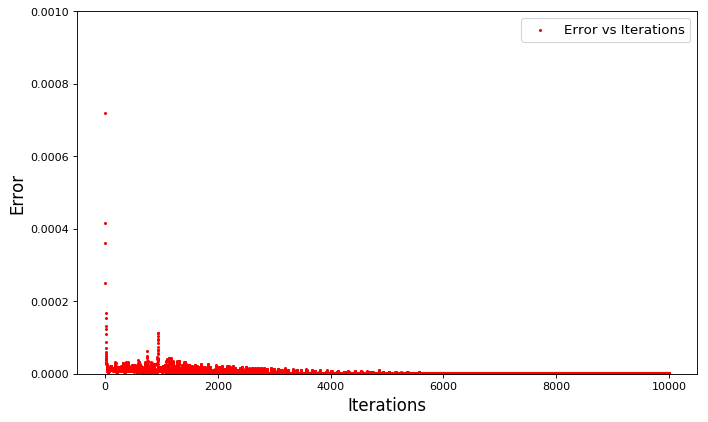

In [14]:
time_ = [i for i in range(len(loss_collection))]
fig=pyplot.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
pyplot.scatter(time_, loss_collection,  s=3, color='r', label="Error vs Iterations")
pyplot.ylabel("Error", fontsize=15)
pyplot.xlabel("Iterations", fontsize=15)
pyplot.ylim(0, 1.e-3)
pyplot.legend(fontsize=12, loc='upper right')
pyplot.show()

In [7]:
pred = []
num_full = fulldata_x.shape[0]
num_batch_full = int(num_full/ batch_size)
for rr in range(num_batch_full):
    input_x = fulldata_x[batch_size*rr:batch_size*(rr+1)]
    temp_pred = sess.run([h5], feed_dict={x:input_x})
    pred.append(temp_pred)

pred = np.array(pred)
pred = np.reshape(pred, [batch_size*num_batch_full, out_dim])

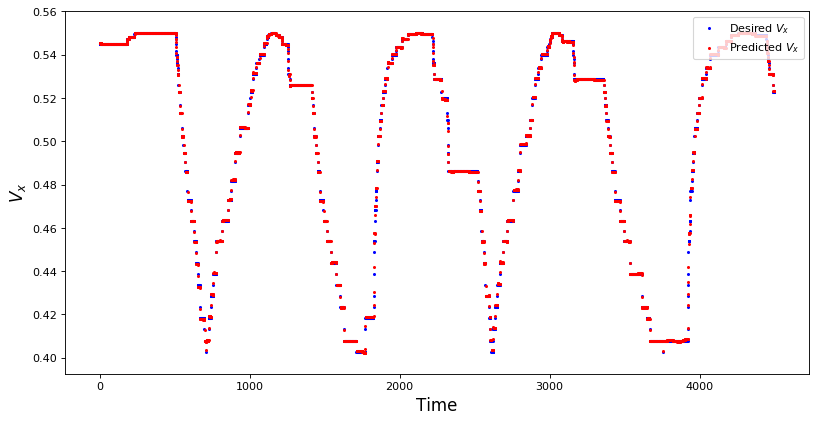

In [8]:
time_ = [i for i in range(batch_size*num_batch_full)]
fig=pyplot.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
pyplot.scatter(time_, fulldata_y[:batch_size*num_batch_full, 0], s=3, color='b', label='Desired $V_x$')
pyplot.scatter(time_, pred[:, 0], s=3, color='r', label="Predicted $V_x$")
pyplot.ylabel("$V_x$", fontsize=15)
pyplot.xlabel("Time", fontsize=15)
pyplot.legend(loc='upper right')
pyplot.show()

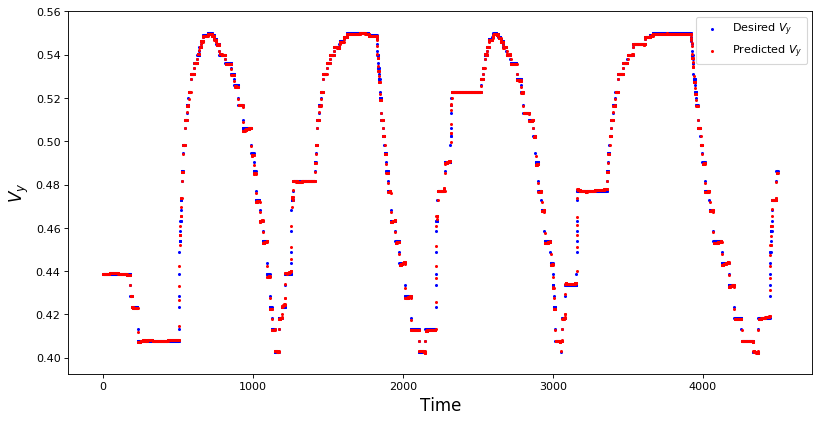

In [9]:
fig=pyplot.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
pyplot.scatter(time_, fulldata_y[:batch_size*num_batch_full, 1], s=3, color='b', label='Desired $V_y$')
pyplot.scatter(time_, pred[:, 1], s=3, color='r', label="Predicted $V_y$")
pyplot.ylabel("$V_y$", fontsize=15)
pyplot.xlabel("Time", fontsize=15)
pyplot.legend(loc='upper right')
pyplot.show()

### Testing

In [ ]:
saver.restore(sess, "nn_model/")

In [16]:
f = open('data.txt', 'r')

testdata_x = []
testdata_y = []

for i, tt in enumerate(f):
    if(i>0):
        tmp = tt.split()
        if(i==1):
            prev = [float(tmp[0]), float(tmp[1])] 
        testdata_x.append([float(tmp[2]), float(tmp[3]), float(tmp[4]), prev[0], prev[1]])
        testdata_y.append([float(tmp[0]), float(tmp[1])])
        prev = testdata_y[-1]         

test_x = np.array(testdata_x, dtype=float)
test_y = np.array(testdata_y, dtype=float) + 0.4

test_x[:, 0] = normalize(test_x[:, 0], max1+0.6, min1-0.6)
test_x[:, 1] = normalize(test_x[:, 1], max2+0.6, min2-0.6)
test_x[:, 2] = normalize(test_x[:, 2], max3+0.6, min3-0.6)
test_x[:, 3] = normalize(test_x[:, 3], max4+0.02, min4-0.02)
test_x[:, 4] = normalize(test_x[:, 4], max5+0.02, min5-0.02)

print(max(test_x[:, 0]), max(test_x[:, 1]), max(test_x[:, 2]), max(test_x[:, 3]), max(test_x[:, 4]))
print(min(test_x[:, 0]), min(test_x[:, 1]), min(test_x[:, 2]), min(test_x[:, 3]), min(test_x[:, 4]))

0.885673803352 0.886284509335 0.898647912476 0.89227632513 0.299985589163
0.114326196648 0.528797879434 0.287441277023 0.866096638005 0.134671939966


In [19]:
pred = []
num_test = test_x.shape[0]
num_batch_test = int(num_test/ batch_size)
for rr in range(num_batch_test):
    input_x = test_x[batch_size*rr:batch_size*(rr+1)]
    temp_pred = sess.run([h5], feed_dict={x:input_x})
    pred.append(temp_pred)

pred = np.array(pred)
pred = np.reshape(pred, [batch_size*num_batch_test, out_dim])

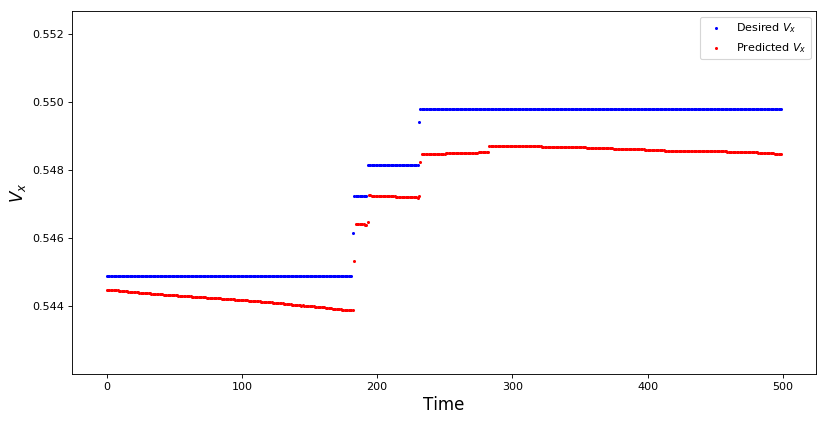

In [21]:
time_ = [i for i in range(batch_size*num_batch_test)]
fig=pyplot.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
pyplot.scatter(time_, test_y[:batch_size*num_batch_test, 0], s=3, color='b', label='Desired $V_x$')
pyplot.scatter(time_, pred[:, 0], s=3, color='r', label="Predicted $V_x$")
pyplot.ylabel("$V_x$", fontsize=15)
pyplot.xlabel("Time", fontsize=15)
pyplot.legend(loc='upper right')
pyplot.show()

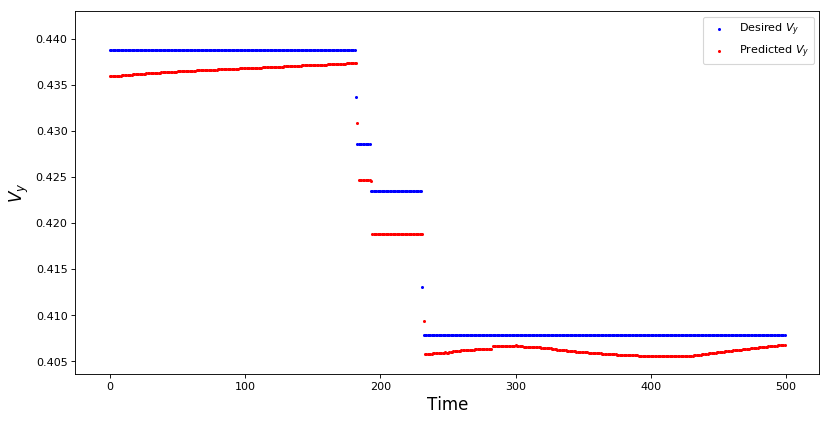

In [22]:
fig=pyplot.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
pyplot.scatter(time_, test_y[:batch_size*num_batch_test, 1], s=3, color='b', label='Desired $V_y$')
pyplot.scatter(time_, pred[:, 1], s=3, color='r', label="Predicted $V_y$")
pyplot.ylabel("$V_y$", fontsize=15)
pyplot.xlabel("Time", fontsize=15)
pyplot.legend(loc='upper right')
pyplot.show()